In [1]:
import pandas as pd
import numpy as np

In [17]:
df = pd.read_csv('echo_ps_matches_all_notes07Feb18.csv')
texts = df.groupby('ICUSTAY_ID')['TEXT'].apply(lambda x: x.sum()).to_frame()

In [8]:
# df_match = pd.read_csv('PSMatchDetails.csv')
# len(set(df_match['icustay_id']))

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer='char_wb', ngram_range=(2,2), min_df = 0)
# cv = CountVectorizer(analyzer='char_wb', ngram_range=(3,3), min_df = 0)

In [11]:
bigrams = cv.fit_transform(texts['TEXT'])

In [13]:
import numpy as np
np.savetxt('bigrams.csv',bigrams.toarray(),delimiter=',')
# np.savetxt('trigrams.csv',trigrams.toarray(),delimiter=',')

In [34]:
df_sub = df.loc[:,['ICUSTAY_ID','PROPENSITY.SCORE','ECHO']].groupby('ICUSTAY_ID').mean()

In [43]:
bigram_df = pd.DataFrame(data=bigrams.toarray())

In [46]:
df_sub.reset_index(drop=True, inplace=True)
texts.reset_index(drop=True, inplace=True)
bigram_df.reset_index(drop=True, inplace=True)
out = pd.concat([df_sub,texts,bigram_df],axis=1)

In [48]:
# out.to_csv('master_bigram.csv')

In [49]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()

In [62]:
LR.fit(out.loc[:,[i for i in range(bigrams.shape[1])]], out['ECHO'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
out['TEXT.PROPENSITY.SCORE'] = LR.predict_proba(out.loc[:,[i for i in range(bigrams.shape[1])]])[:,1]

In [70]:
out.loc[:,['ECHO','PROPENSITY.SCORE','TEXT.PROPENSITY.SCORE']]

,ECHO,PROPENSITY.SCORE,TEXT.PROPENSITY.SCORE
0,1,0.512780,0.425413
1,1,0.768120,0.414199
2,1,0.483118,0.658376
3,0,0.596660,0.440875
4,1,0.666952,0.831680
5,0,0.515942,0.006778
6,1,0.773341,0.713861
7,0,0.437484,0.167780
8,0,0.604153,0.507339
9,1,0.268699,0.917705


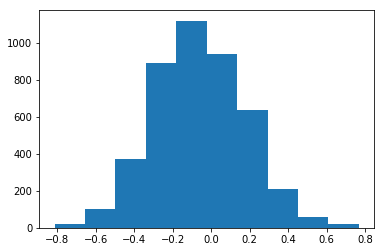

In [80]:
diff = out['PROPENSITY.SCORE']-out['TEXT.PROPENSITY.SCORE']
import matplotlib.pyplot as plt
plt.hist(diff)
plt.show()


In [82]:
np.max(out['TEXT.PROPENSITY.SCORE'])

1.0

# Ranking

In [8]:
# load bigrams
bigrams=np.loadtxt('bigrams.csv',delimiter=',')

In [121]:
# group by ICUSTAY_ID
df_sub = df.loc[:,['ICUSTAY_ID','MATCH.ID','ECHO']].groupby('ICUSTAY_ID').mean()

In [154]:
# get row nums for treatment and control
treat_ids = np.where(df_sub['ECHO']==1)[0]
control_ids = np.where(df_sub['ECHO']==0)[0]

In [155]:
# calc pairwise cos similarity between treat and control
from sklearn.metrics.pairwise import cosine_similarity
cosines = cosine_similarity(bigrams[treat_ids],bigrams[control_ids])

In [156]:
# sort rankings and return row ID's
rankings = np.argsort(-cosines)

In [157]:
# convert matched IDs to row ID's
def find_el(el):
    res = np.where(df_sub.index.values==el)
    if len(res[0]) == 0:
        return None
    return res[0][0]
f = np.vectorize(find_el)
matched_ids=f(df_sub['MATCH.ID'])

In [167]:
# for each treatment row ID, find where the matched ID is in terms of the pairwise cos sim over control ID's
positions = []
for i,treat_id in enumerate(treat_ids):
    ranking = rankings[i]
    id_to_find = matched_ids[treat_id]
    if id_to_find:
        id = np.where(ranking == id_to_find)[0]
        if id:
            positions.append(id[0])
    else:
        positions.append(None)
positions = np.array(positions)

/Users/kojin/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


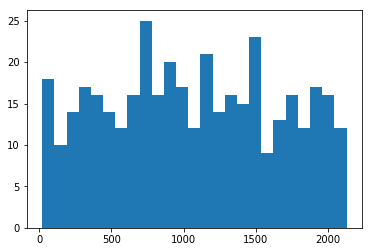

In [177]:
import matplotlib.pyplot as plt
data=positions[positions!=None]
plt.hist(data.astype(int),bins=25)
plt.show()